<a href="https://colab.research.google.com/github/ag-yash/kds-hack/blob/main/ReadyToPublish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install datasets

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
# Load the datasets from the provided paths
train_df = pd.read_csv('/content/Training_Dataset_with_label.csv')
test_df = pd.read_csv('/content/organized_content (3).csv')

In [ ]:
# Inspect the DataFrame to check for missing values
print(f"Missing values in train_df:\n{train_df.isnull().sum()}")
print(f"Missing values in test_df:\n{test_df.isnull().sum()}")

In [ ]:
print(f"Number of rows before processing missing labels: {train_df.shape[0]}")

In [ ]:
train_df['text'] = (train_df['Abstract'] + " " + train_df['Introduction'] + " " +
                    train_df['Methodology'] + " " + train_df['Results'] + " " +
                    train_df['Conclusion']).fillna('')
test_df['text'] = (test_df['Abstract'] + " " + test_df['Introduction'] + " " +
                   test_df['Methodology'] + " " + test_df['Results'] + " " +
                   test_df['Conclusion']).fillna('')

In [ ]:
# Debugging step: Check the 'text' column in both train_df and test_df
print("Checking the first few rows of 'train_df' to verify 'text' column creation:")
print(train_df[['text']].head())

In [ ]:
print("Checking the first few rows of 'test_df' to verify 'text' column creation:")
print(test_df[['text']].head())

In [ ]:
# Check if any missing values still exist in 'text' column
print(f"Missing values in train_df after text combination:\n{train_df.isnull().sum()}")
print(f"Missing values in test_df after text combination:\n{test_df.isnull().sum()}")

In [ ]:
# Since 'Publishable' column is not in the test dataset, we only use the 'text' from train_df
train_labels = train_df['Publishable'].tolist()  # Only train labels are needed for training

# Initialize the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
# Tokenize function
def tokenize_function(texts):
    return tokenizer(texts, padding=True, truncation=True, max_length=512)

In [ ]:
# Custom Dataset class
class ResearchPaperDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenize_function(texts)
        self.labels = torch.tensor(labels, dtype=torch.long) if labels is not None else None

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df['text'].tolist(),
    train_labels,
    test_size=0.1,
    random_state=42
)

In [ ]:
train_dataset = ResearchPaperDataset(train_texts, train_labels)
val_dataset = ResearchPaperDataset(val_texts, val_labels)
test_dataset = ResearchPaperDataset(test_df['text'].tolist())  # No labels for testing

In [ ]:
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [ ]:
# Initialize the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

In [ ]:
def train(model, train_loader, optimizer):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(train_loader)

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    preds = []
    true_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)

            preds.extend(predictions.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average='weighted')  # Weighted for imbalanced classes
    return accuracy, f1


In [ ]:
# Train and evaluate the model
for epoch in range(20):
    print(f"Epoch {epoch + 1}")
    train_loss = train(model, train_loader, optimizer)
    val_accuracy, val_f1 = evaluate(model, val_loader)
    print(f"Training loss: {train_loss:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Validation F1 score: {val_f1:.4f}")

In [ ]:
# Predict function for test data
def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, dim=-1).cpu().numpy())
    return predictions

In [ ]:
# Plot the training loss graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='blue', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1
Training loss: 0.6276
Validation accuracy: 1.0000
Validation F1 score: 1.0000
Epoch 2
Training loss: 0.6167
Validation accuracy: 1.0000
Validation F1 score: 1.0000
Epoch 3
Training loss: 0.5932
Validation accuracy: 1.0000
Validation F1 score: 1.0000
Epoch 4
Training loss: 0.5691
Validation accuracy: 1.0000
Validation F1 score: 1.0000
Epoch 5
Training loss: 0.5517
Validation accuracy: 1.0000
Validation F1 score: 1.0000
Epoch 6
Training loss: 0.5138
Validation accuracy: 1.0000
Validation F1 score: 1.0000
Epoch 7
Training loss: 0.5295
Validation accuracy: 1.0000
Validation F1 score: 1.0000
Epoch 8
Training loss: 0.4928
Validation accuracy: 1.0000
Validation F1 score: 1.0000
Epoch 9
Training loss: 0.4667
Validation accuracy: 1.0000
Validation F1 score: 1.0000
Epoch 10
Training loss: 0.4342
Validation accuracy: 1.0000
Validation F1 score: 1.0000
Epoch 11
Training loss: 0.4020
Validation accuracy: 1.0000
Validation F1 score: 1.0000
Epoch 12
Training loss: 0.4131
Validation accuracy: 

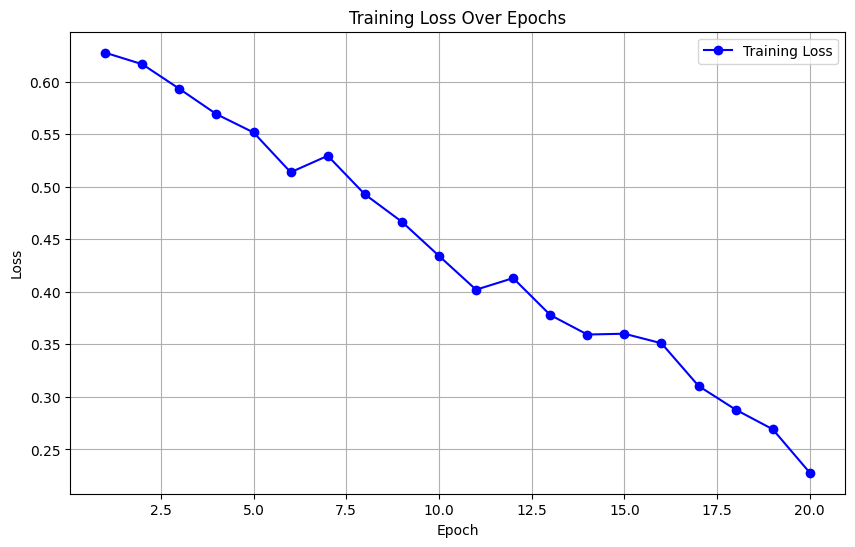

Test Predictions: [1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]


In [ ]:
# Get predictions on the test data
test_predictions = predict(model, test_loader)
print(f"Test Predictions: {test_predictions}")

In [ ]:
print(train_df.head(5))

   Filename                                           Abstract  \
0  R007.pdf  The growing focus on leveraging computer visio...   
1  R014.pdf  This research examines a specific category of ...   
2  R002.pdf  The perpetual oscillations of quantum fluctuat...   
3  R009.pdf  This study demonstrates that incorporating the...   
4  R010.pdf  Parkinson’s disease (PD) is a progressive neur...   

                                        Introduction  \
0  The convergence of computer vision technologie...   
1  The recent advancements in machine learning mo...   
2  The deployment of novel spectroscopic methodol...   
3  The concept of the "wisdom of the crowd" posit...   
4  Parkinson’s disease (PD) is a debilitating neu...   

                                         Methodology  \
0  The team’s research employs multi-view reconst...   
1                                                NaN   
2  The intricacies of photosynthetic methodologie...   
3                                         

In [ ]:
print(test_df.head(5))

   Filename                                           Abstract  \
0  P089.pdf  This research investigates the conditions unde...   
1  P014.pdf  This document outlines our contribution to the...   
2  P054.pdf  The growing focus on computer vision for appli...   
3  P057.pdf  We introduce a novel approach to human-machine...   
4  P112.pdf  The rapid increase of genomic sequence data re...   

                                        Introduction  \
0  In contemporary machine learning practice, the...   
1  The field of multimodal speech perception has ...   
2  The merging of computer vision with the culina...   
3  The ongoing technological advancements are res...   
4  Genomic sequence data is growing at an unprece...   

                                         Methodology  \
0                                                NaN   
1  The active speaker detection system is compose...   
2  The team’s research employs multi-view reconst...   
3  The engineered system includes a camera

In [ ]:
# Predict labels for the test dataset
test_predictions = predict(model, test_loader)

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'Text': test_texts,  # The original text
    'Predicted Label': test_predictions  # The predicted labels
})

# Save the results to a CSV file
results_df.to_csv('/content/test_predictions.csv', index=False)
print("Predictions saved to test_predictions.csv")